In [1]:
!pip install import_ipynb

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [3]:
#%cd /content/gdrive/MyDrive/Colab Notebooks/OUTTA
#!ls

In [4]:
import import_ipynb

from nlp_Preproc_final import preproc
from nlp_model_final import get_model, get_model_with_params, BertModelInitialization
import random
import numpy as np
import pandas as pd
import torch
from tqdm.notebook import tqdm
import time

importing Jupyter notebook from nlp_Preproc_final.ipynb
  Using cached numpy-1.16.6-cp38-cp38-win_amd64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 0.20.1 requires numpy>=1.18, but you have numpy 1.16.6 which is incompatible.
tensorflow 2.9.1 requires numpy>=1.20, but you have numpy 1.16.6 which is incompatible.
tensorflow 2.9.1 requires tensorboard<2.10,>=2.9, but you have tensorboard 2.10.0 which is incompatible.
tensorboard 2.10.0 requires requests<3,>=2.21.0, but you have requests 2.18.4 which is incompatible.
seaborn 0.12.0 requires numpy>=1.17, but you have numpy 1.16.6 which is incompatible.
scikit-learn 1.1.1 requires numpy>=1.17.3, but you have numpy 1.16.6 which is incompatible.
pandas 1.4.3 requires numpy>=1.18.5; platform_machine != "aarch64" and platform_machine != "arm64" and python_version < "3.10", but you have numpy 1.16.6 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.16.6 which is incompatible.
m


    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.1 requires tensorboard<2.10,>=2.9, but you have tensorboard 2.10.0 which is incompatible.
tensorboard 2.10.0 requires requests<3,>=2.21.0, but you have requests 2.18.4 which is incompatible.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.23.4 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.4 which is incompatible.
mxnet 1.7.0.post2 requires numpy<1.17.0,>=1.8.2, but you have numpy 1.23.4 which is incompatible.



  Using cached numpy-1.23.4-cp38-cp38-win_amd64.whl (14.7 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.16.6
    Uninstalling numpy-1.16.6:
      Successfully uninstalled numpy-1.16.6


C:\Users\user\anaconda3\envs\ml\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


2.9.1


importing Jupyter notebook from nlp_model_final.ipynb


In [5]:
# 정확도 계산 함수
def accuracy(preds, labels):
    f_pred = np.argmax(preds, axis=1).flatten()
    f_labels = labels.flatten()
    return np.sum(f_pred == f_labels) / len(f_labels)

In [6]:
# 재현을 위해 랜덤시드 고정
seed_val = 2022

**잠깐 ✔ 랜덤시드 고정이란 무엇인가?**
> 학습된 모델의 결과를 동일하게 재현(Reproduction)하는 것은 여러가지 상황에서 팔요하다.  
> 모델을 돌릴 때마다 결과가 달라지지 않도록 고정하는 것이다.

- 수상자가 되어 코드의 정합성을 검증 받게 될 경우,

- 경진대회 참가 도중 팀을 이루어 결과를 공유해야 되는 경우,

- 논문을 작성하여 그 결과를 Reproduction 해야하는 경우 등 여러 상황에서 필요하다.

참고 자료:
https://dacon.io/codeshare/2363
https://pytorch.org/docs/stable/notes/randomness.html


In [7]:
# 랜덤하게 데이터를 추출하기 위한 seed 값 설정
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [8]:
from tokenization_kobert import KoBertTokenizer

# 전체 데이터를 불러오자.
whole_dataset = pd.read_excel('data/감정분류데이터셋.xlsx')

# KoBERTTokenizer를 불러오자.
tokenizer = KoBertTokenizer.from_pretrained("monologg/kobert")

train_dataloader, validation_dataloader = preproc(tokenizer, whole_dataset)

length of whole_data : 29991
length of train_data : 26991


<string>:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:204.)


In [9]:
# BertModel 생성해서 GPU 혹은 CPU에 등록
# 기존 Device에 등록된 BertModel은 초기화되니, 유의하여 사용할 것.
# 한 번만 실행하고, 그 이후로는 사용하지 않도록 조심!
BertModelInitialization()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# GPU 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, optimizer, scheduler, epochs, criterion = get_model_with_params(len(train_dataloader), device, torch.cuda.is_available())

# 그래디언트 초기화
model.zero_grad()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



========1번째 Epoch / 전체 5회 ========
훈련 중


  0%|          | 0/844 [00:00<?, ?it/s]

0번째 까지의 평균 loss : 0.0
100번째 까지의 평균 loss : 1.8875537669658662
200번째 까지의 평균 loss : 1.4509938943386078
300번째 까지의 평균 loss : 0.8495236408710479
400번째 까지의 평균 loss : 0.5542348913848401
500번째 까지의 평균 loss : 0.49966470390558243
600번째 까지의 평균 loss : 0.4151381673663855
700번째 까지의 평균 loss : 0.37502781018614767
800번째 까지의 평균 loss : 0.410758535861969

training @ epoch 1 .. Train loss = 0.78 Train Accuracy = 0.73 

검증 중
Val loss = 0.37 .. Val Accuracy = 0.87 

========2번째 Epoch / 전체 5회 ========
훈련 중


  0%|          | 0/844 [00:00<?, ?it/s]

0번째 까지의 평균 loss : 0.0
100번째 까지의 평균 loss : 0.304215556755662
200번째 까지의 평균 loss : 0.2939295771718025
300번째 까지의 평균 loss : 0.30072483025491237
400번째 까지의 평균 loss : 0.2950590277835727
500번째 까지의 평균 loss : 0.3048558298125863
600번째 까지의 평균 loss : 0.27864057186990976
700번째 까지의 평균 loss : 0.2936717288382351
800번째 까지의 평균 loss : 0.26160909308120606

training @ epoch 2 .. Train loss = 0.29 Train Accuracy = 0.91 

검증 중
Val loss = 0.31 .. Val Accuracy = 0.90 

========3번째 Epoch / 전체 5회 ========
훈련 중


  0%|          | 0/844 [00:00<?, ?it/s]

0번째 까지의 평균 loss : 0.0
100번째 까지의 평균 loss : 0.18164732477627696
200번째 까지의 평균 loss : 0.222244646018371
300번째 까지의 평균 loss : 0.18507378680631517
400번째 까지의 평균 loss : 0.20707498762756585
500번째 까지의 평균 loss : 0.17428661899641157
600번째 까지의 평균 loss : 0.1939831010950729
700번째 까지의 평균 loss : 0.1544410687033087
800번째 까지의 평균 loss : 0.16852827784605323

training @ epoch 3 .. Train loss = 0.19 Train Accuracy = 0.94 

검증 중
Val loss = 0.30 .. Val Accuracy = 0.91 

========4번째 Epoch / 전체 5회 ========
훈련 중


  0%|          | 0/844 [00:00<?, ?it/s]

0번째 까지의 평균 loss : 0.0
100번째 까지의 평균 loss : 0.11531939410837368
200번째 까지의 평균 loss : 0.11260150750400498
300번째 까지의 평균 loss : 0.11704549623420463
400번째 까지의 평균 loss : 0.10674681603908538
500번째 까지의 평균 loss : 0.11837502902140841
600번째 까지의 평균 loss : 0.1052116043958813
700번째 까지의 평균 loss : 0.12188039152882993
800번째 까지의 평균 loss : 0.10838056570617483

training @ epoch 4 .. Train loss = 0.11 Train Accuracy = 0.96 

검증 중
Val loss = 0.34 .. Val Accuracy = 0.92 

========5번째 Epoch / 전체 5회 ========
훈련 중


  0%|          | 0/844 [00:00<?, ?it/s]

0번째 까지의 평균 loss : 0.0
100번째 까지의 평균 loss : 0.07570520400302484
200번째 까지의 평균 loss : 0.060468853543279695
300번째 까지의 평균 loss : 0.06916832951828837
400번째 까지의 평균 loss : 0.06932394689065405
500번째 까지의 평균 loss : 0.0687312641274184
600번째 까지의 평균 loss : 0.06384872040129266
700번째 까지의 평균 loss : 0.08068216140614823
800번째 까지의 평균 loss : 0.06948995956103317

training @ epoch 5 .. Train loss = 0.07 Train Accuracy = 0.98 

검증 중
Val loss = 0.35 .. Val Accuracy = 0.92 

Training complete!


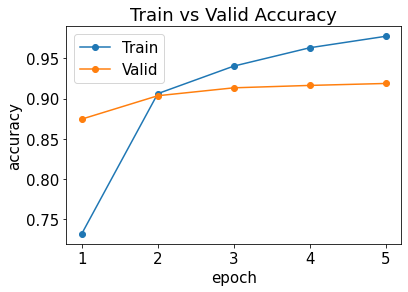

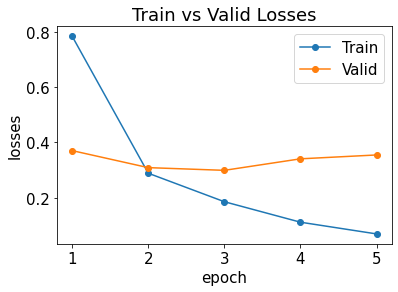

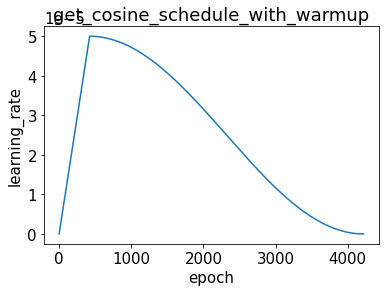

In [11]:
import matplotlib.pyplot as plt
# 에폭만큼 반복


train_accs=[]
train_losses=[]
val_losses=[]
val_accs=[]
lrs=[]

for epoch_i in range(epochs):
    print("")
    print('========{:}번째 Epoch / 전체 {:}회 ========'.format(epoch_i + 1, epochs))
    print('훈련 중')

    t0 = time.time() # 시작 시간 설정
    total_loss = 0 # 로스 초기화
    sum_loss = 0

    train_loss, train_accuracy = 0, 0
    nb_train_steps, nb_train_examples = 0, 0


    model.train()  # 훈련모드로 변경

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(tqdm(train_dataloader)):
        
        if step % 100 == 0:
            print("{}번째 까지의 평균 loss : {}".format(step, sum_loss/100))
            sum_loss = 0

        batch = tuple(t.to(device) for t in batch)   # 배치를 GPU에 넣음
        b_input_ids, b_input_mask, b_labels = batch  # 배치에서 데이터 추출
        
        # nlp_model_final.ipynb 파일에서 BertClassifier 클래스를 정의하고 해당 클래스를 활용하여 'model'을 생성한 바 있다.
        # 위의 코드에서 정의한 배치 데이터를 'model'의 입력 변수로 이용하여, 배치에 대한 forward를 수행해보자.   
        # Hint: BertClassifier의 forward를 수행하기 위해서는 input_ids, attention_mask 변수를 입력받아야 한다. 
        ## 여기에 코드 작성
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        # 위에서 산출된 7차원 벡터와 criterion, b_labels를 활용해서 loss를 계산해보자.
        ## 여기에 코드 작성
        b_labels=b_labels.type(torch.LongTensor).to(device)
        
        loss = criterion(outputs[0], b_labels)
        total_loss += loss.item() # 총 로스 계산
        sum_loss += loss.item()

        loss.backward() # Backward 수행으로 그래디언트 계산
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # 그래디언트 클리핑
        optimizer.step() # 그래디언트를 통해 가중치 파라미터 업데이트
        lrs.append(
        optimizer.param_groups[0]["lr"]
        )
        scheduler.step()  # 스케줄러로 학습률 감소
        
        outputs = outputs[0]
        outputs = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_train_accuracy = accuracy(outputs, label_ids)
        train_accuracy += tmp_train_accuracy
        nb_train_steps += 1

        model.zero_grad() # 그래디언트 초기화
        
    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)   
    Train_acc=train_accuracy/nb_train_steps  
    print("")
    print(f'training @ epoch {epoch_i+1} .. Train loss = {avg_train_loss:.2f} Train Accuracy = {Train_acc:.2f} ')
    train_accs.append(Train_acc)
    train_losses.append(avg_train_loss)
    #### 검증 ####
    
    print("")
    print("검증 중")

    t0 = time.time() #시작 시간
    model.eval()
    total_loss=0
    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():
            # 위 train과 같은 논리. forward를 수행해서 7차원 벡터 출력    
            # outputs = ~~ 과 같이 작성
            ## 여기에 코드 작성
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            
            b_labels=b_labels.type(torch.LongTensor).to(device)
            
            loss = criterion(outputs[0], b_labels)
        total_loss += loss.item() # 총 로스 계산
        # CPU로 데이터 이동
        outputs = outputs[0]
        outputs = outputs.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 위에 구현한 accuracy 함수를 활용해서 출력 로짓과 라벨을 비교하여 정확도 계산
        # tmp_eval_accuracy = ~~ 와 같이 작성
        ## 여기에 코드 작성
        tmp_eval_accuracy = accuracy(outputs, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    avg_val_loss = total_loss / len(validation_dataloader)
    val_acc=eval_accuracy/nb_eval_steps
    print(f'Val loss = {avg_val_loss:.2f} .. Val Accuracy = {val_acc:.2f} ')
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)
# 학습된 모델을 해당 PATH에 저장
PATH = "model.pt"
torch.save(model.state_dict(), PATH)


plt.rcParams.update({'font.size':15})

plt.figure(1)
plt.plot(np.arange(1,epochs+1),train_accs,'-o')
plt.plot(np.arange(1,epochs+1),val_accs,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.savefig('bert_Accuracy_graph.png',
            format='png', dpi=200)

plt.figure(2)
plt.plot(np.arange(1,epochs+1),train_losses,'-o')
plt.plot(np.arange(1,epochs+1),val_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.savefig('bert_Loss_graph.png',
            format='png', dpi=200)


plt.figure(3)
plt.plot(lrs)
plt.xlabel('epoch')
plt.ylabel('learning_rate')
plt.title('get_cosine_schedule_with_warmup')
plt.savefig('bert_learning_rate.png',
        format='png', dpi=200)

print("")
print("Training complete!")